In [1]:
# Copyright (c) 2015-2016, the authors (see AUTHORS.txt).
# Licensed under the BSD 3-clause license (see LICENSE.txt)
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook

import unittest
import deepgp
import GPy
import os
import h5py
import tables

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs
from sklearn.decomposition import PCA
import scipy

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import sparse_ops

import rbf_kernel
from densities import multivariate_normal

base_path = os.path.dirname("__file__")

In [2]:
# def const(x):
#     x = tf.constant(x,dtype=tf.float32)
#     return x

# plt.subplots(2,3,figsize=(10,6))

# def build_toy_dataset(N, D, K, Ngrid = 100, prior_l=2, prior_sig_f=1, l=0.5, sig_f=1, sig_n=1e-1):
#     Nall = Ngrid + N
#     tgrid = np.linspace(-5, 5, num=N).reshape(-1,1)

#     sess = ed.get_session()
#     with sess.as_default():
#         Kprior = rbf(const(tgrid),lengthscale=const(prior_l),variance=const(prior_sig_f)).eval()

#     z_mu = np.zeros(N)
#     z_cov = Kprior + 1e-10*np.eye(N)
#     z = np.random.multivariate_normal(z_mu, z_cov).T.reshape(-1,1)
#     zgrid = np.linspace(z.min(), z.max(), num=Ngrid).reshape(-1,1)
#     zall = np.vstack((z,zgrid))

#     plt.subplot(2,3,1)
#     plt.imshow(Kprior)
#     plt.colorbar()
#     plt.subplot(2,3,2)
#     plt.plot(z)

#     with sess.as_default():
#         Kzall = rbf(const(zall),lengthscale=const(l),variance=const(sig_f)).eval()

#     Kz = Kzall[:N,:N]
#     xall = np.random.multivariate_normal(np.zeros(Nall), Kzall, D).T
#     x = xall[:N,:]
#     xgrid = xall[N:,:]
#     noise = np.random.randn(x.shape[0],x.shape[1])
#     x = x + sig_n*noise

#     plt.subplot(2,3,4)
#     plt.imshow(Kz)
#     plt.colorbar()
#     plt.subplot(2,3,5)
#     plt.imshow(np.cov(x))
#     plt.colorbar()
#     plt.subplot(2,3,6)
#     plt.plot(xgrid[:,:5])

#     return x,xgrid,z,zgrid,tgrid,Kz,Kprior

# N = 500  # number of data points, number of time points
# D = 200  # data dimensionality, number of neurons
# K = 1  # latent dimensionality

# x_true, xgrid, z_true, zgrid, tgrid, Kz_true, Kprior_true = build_toy_dataset(N, D, K)

# print("Number of data points N={}".format(N))
# print("Number of features D={}".format(D))
# print("Number of latent dimensions K={}".format(K))

# pca = PCA(n_components=1)
# z_init = pca.fit_transform(x_true)

# # visualize the covariance of Z
# plt.subplot(2,3,3)
# plt.plot(z_init)

# scipy.io.savemat('syn.mat',mdict={'x_true':x_true, 'xgrid':xgrid, 'z_true':z_true, 'zgrid':zgrid, 
#                                   'tgrid':tgrid, 'Kz_true':Kz_true, 'Kprior_true':Kprior_true})

<IPython.core.display.Javascript object>


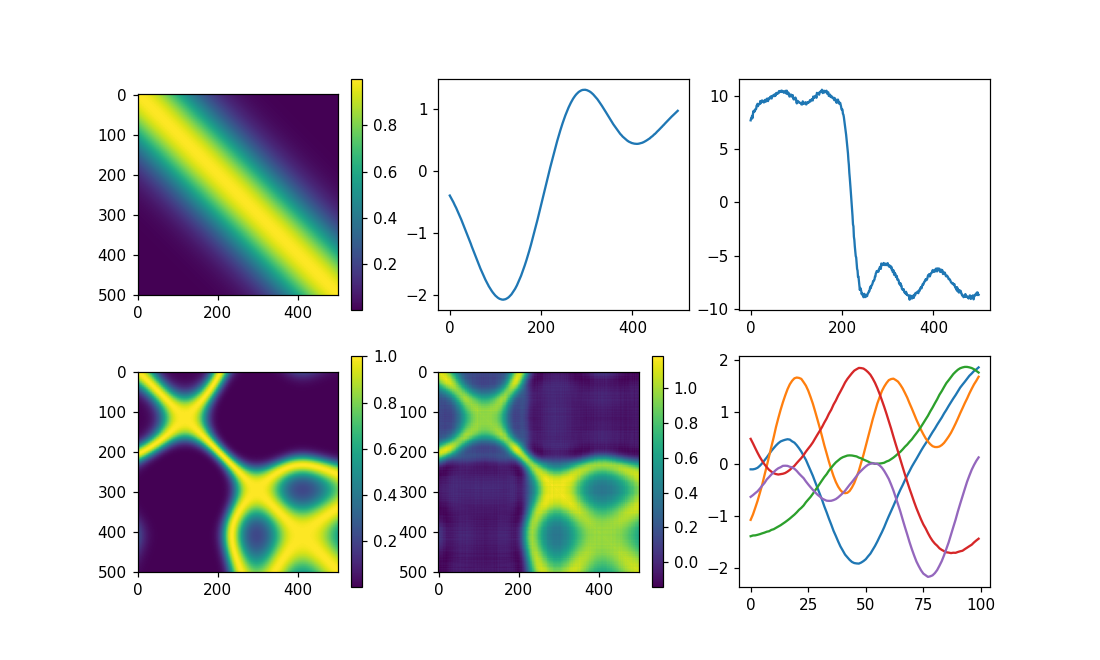

Number of data points N=500
Number of features D=200
Number of latent dimensions K=1


In [3]:
data = scipy.io.loadmat('syn.mat')
x_true = data['x_true']
xgrid = data['xgrid']
z_true = data['z_true']
zgrid = data['zgrid']
tgrid = data['tgrid']
Kz_true = data['Kz_true']
Kprior_true = data['Kprior_true']

N = x_true.shape[0]
D = x_true.shape[1]
K = z_true.shape[1]

pca = PCA(n_components=K)
z_init = pca.fit_transform(x_true)

plt.subplots(2,3,figsize=(10,6))
plt.subplot(2,3,1)
plt.imshow(Kprior_true)
plt.colorbar()
plt.subplot(2,3,2)
plt.plot(z_true)

plt.subplot(2,3,4)
plt.imshow(Kz_true)
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(np.cov(x_true))
plt.colorbar()
plt.subplot(2,3,6)
plt.plot(xgrid[:,:5])
plt.subplot(2,3,3)
plt.plot(z_init)

print("Number of data points N={}".format(N))
print("Number of features D={}".format(D))
print("Number of latent dimensions K={}".format(K))

In [4]:
# define functions to create weight and bias variables, from TensorFlow.org
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(-0.1, shape=shape)
  return tf.Variable(initial)

def const(x):
    x = tf.constant(x,dtype=tf.float32)
    return x

# z = tf.Variable(z_init, dtype=tf.float32)
z = tf.Variable(tf.ones([N, K])*1e-2, dtype=tf.float32)
x = tf.placeholder(tf.float32, shape=[N, D])

prior_sig_n = const(np.log(1))
sig_n = const(np.log(1))
# sig_f = const(np.log(1))
# l = const(np.log(1))
# sig_n = tf.Variable(np.log(0.01), dtype=tf.float32)
sig_f = tf.Variable(np.log(1), dtype=tf.float32)
l = tf.Variable(np.log(1), dtype=tf.float32)

Kz = rbf(z,lengthscale=tf.exp(l),variance=tf.exp(sig_f))+tf.exp(sig_n)*tf.eye(N)

loss = - multivariate_normal(x, 0, tf.cholesky(Kz)) + 0.5*tf.exp(prior_sig_n)*tf.trace(tf.matmul(tf.transpose(z),z))
opt = tf.train.RMSPropOptimizer(learning_rate=0.005, decay=0.95, momentum=0.1).minimize(loss)

# train network
epochs = 5000
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
fd = {x:x_true}
for epoch in range(epochs) :
    opt.run(feed_dict=fd)
    current_loss,sig_f_est,sig_n_est,l_est = sess.run([loss,sig_f,sig_n,l],feed_dict=fd) 
    if epoch % 100 == 0:
        print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(current_loss)
             , "sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
             , "l_est=", "{:.9f}".format(np.exp(l_est)))


Epoch: 0001 loss= 127114.828125000 sig_f_est= 0.977936327 sig_n_est= 1.000000000 l_est= 0.999999940
Epoch: 0101 loss= 100338.468750000 sig_f_est= 1.654928684 sig_n_est= 1.000000000 l_est= 0.520779490
Epoch: 0201 loss= 96110.765625000 sig_f_est= 2.143275738 sig_n_est= 1.000000000 l_est= 0.352900118
Epoch: 0301 loss= 95999.617187500 sig_f_est= 1.370788693 sig_n_est= 1.000000000 l_est= 0.301754117
Epoch: 0401 loss= 95974.523437500 sig_f_est= 1.058902979 sig_n_est= 1.000000000 l_est= 0.266930908
Epoch: 0501 loss= 95965.093750000 sig_f_est= 1.053788185 sig_n_est= 1.000000000 l_est= 0.249873668
Epoch: 0601 loss= 95957.851562500 sig_f_est= 1.057091713 sig_n_est= 1.000000000 l_est= 0.234726027
Epoch: 0701 loss= 95952.359375000 sig_f_est= 1.057490230 sig_n_est= 1.000000000 l_est= 0.222730815
Epoch: 0801 loss= 95948.039062500 sig_f_est= 1.055437207 sig_n_est= 1.000000000 l_est= 0.213096783
Epoch: 0901 loss= 95944.617187500 sig_f_est= 1.052552104 sig_n_est= 1.000000000 l_est= 0.204977840
Epoch: 1

In [5]:
# z_est, sig_f_est, sig_n_est, l_est = sess.run([z,sig_f,sig_n,l],feed_dict=fd)
# print("sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
#       , "l_est=", "{:.9f}".format(np.exp(l_est)))

# z = tf.Variable(z_est, dtype=tf.float32)
# x = tf.placeholder(tf.float32, shape=[N, D])

# sig_n = const(np.log(0.1))
# sig_f = const(sig_f_est)
# l = const(l_est)
# # sig_n = tf.Variable(np.log(0.1), dtype=tf.float32)
# # sig_f = tf.Variable(np.log(1), dtype=tf.float32)
# # l = tf.Variable(np.log(10), dtype=tf.float32)

# Kz = rbf(z,lengthscale=tf.exp(l),variance=tf.exp(sig_f))+tf.exp(sig_n)*tf.eye(N)

# loss = - multivariate_normal(x, 0, tf.cholesky(Kz)) + 0.5*tf.exp(prior_sig_n)*tf.trace(tf.matmul(tf.transpose(z),z))
# opt = tf.train.RMSPropOptimizer(learning_rate=0.005, decay=0.95, momentum=0.1).minimize(loss)

# # train network
# epochs = 1000
# sess = tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())
# fd = {x:x_true}
# for epoch in range(epochs) :
#     opt.run(feed_dict=fd)
#     current_loss,sig_f_est,sig_n_est,l_est = sess.run([loss,sig_f,sig_n,l],feed_dict=fd) 
#     if epoch % 100 == 0:
#         print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(current_loss)
#              , "sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
#              , "l_est=", "{:.9f}".format(np.exp(l_est)))


sig_f_est= 1.049942732 sig_n_est= 1.000000000 l_est= 0.130097643


<IPython.core.display.Javascript object>


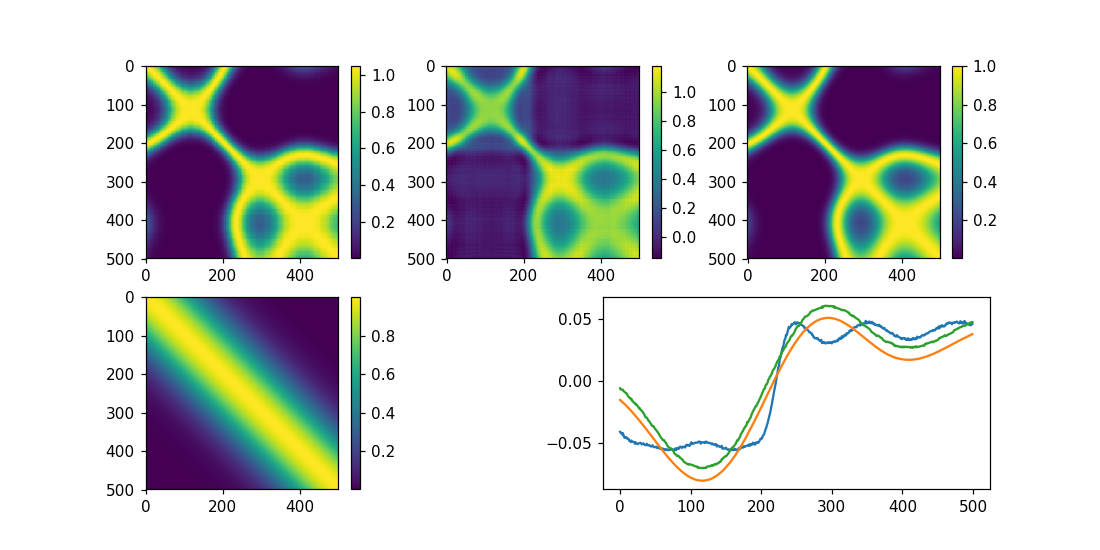

In [6]:
z_est, sig_f_est, sig_n_est, l_est = sess.run([z,sig_f,sig_n,l],feed_dict=fd)
print("sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
      , "l_est=", "{:.9f}".format(np.exp(l_est)))

Kz = rbf(const(z_est),lengthscale=tf.exp(l_est),variance=tf.exp(sig_f_est)).eval()

def match_z(x,z):
    cp = np.corrcoef(x.T,z.T)[0,1]
    cn = np.corrcoef(-x.T,z.T)[0,1]
    if cp<cn:
        return -x
    else:
        return x
    
plt.subplots(2,3,figsize=(10,5))
plt.subplot(2,3,1)
plt.imshow(Kz)
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(np.cov(x_true))
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(Kz_true)
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(Kprior_true)
plt.colorbar()
plt.subplot(2,2,4)
plt.plot(match_z(z_init/np.linalg.norm(z_init),z_true/np.linalg.norm(z_true)))
plt.plot(z_true/np.linalg.norm(z_true))
plt.plot(match_z(z_est/np.linalg.norm(z_est),z_true/np.linalg.norm(z_true)))
